Saving stroke_risk_dataset.csv to stroke_risk_dataset (2).csv
Dataset Shape: (70000, 18)

First 5 rows:
   Chest Pain  Shortness of Breath  Irregular Heartbeat  Fatigue & Weakness  \
0           0                    1                    1                   1   
1           0                    0                    1                   0   
2           1                    0                    0                   1   
3           1                    0                    1                   1   
4           0                    0                    1                   0   

   Dizziness  Swelling (Edema)  Pain in Neck/Jaw/Shoulder/Back  \
0          0                 0                               0   
1          0                 1                               0   
2          1                 1                               0   
3          0                 1                               1   
4          0                 1                               0   

   Excessive Sweating  P

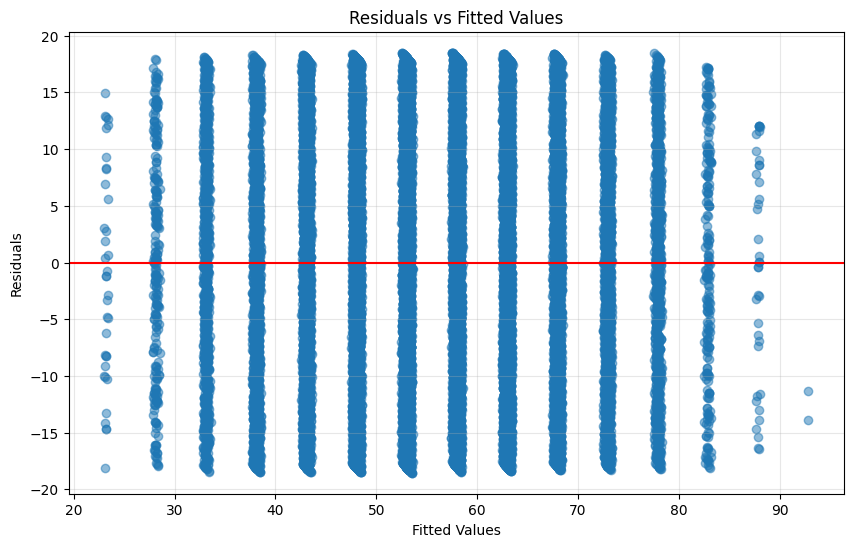

<Figure size 1000x600 with 0 Axes>

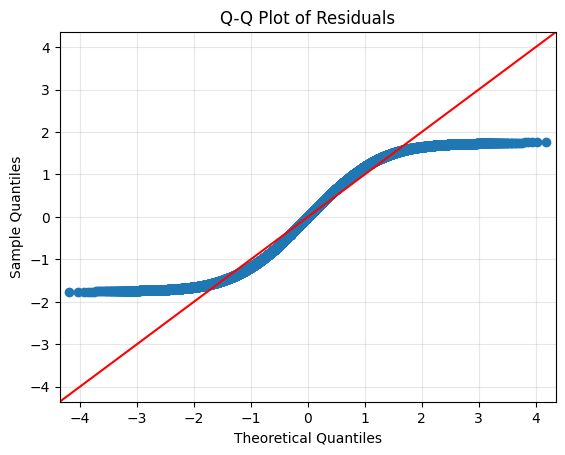


Shapiro-Wilk Test for Normality of Residuals:
Statistic: 0.9549, p-value: 0.0000
Normality Test Passed: False


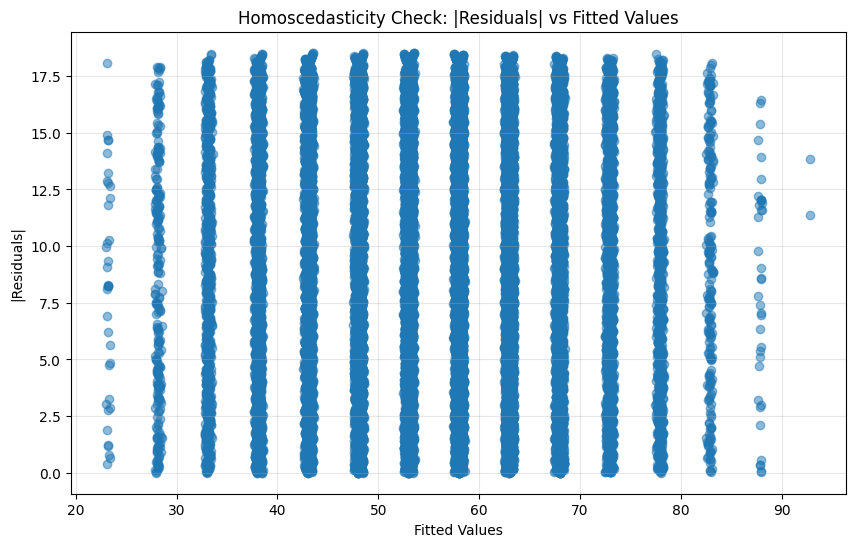


Breusch-Pagan Test for Homoscedasticity:
Statistic: 20.9349, p-value: 0.1389
Homoscedasticity Test Passed: True


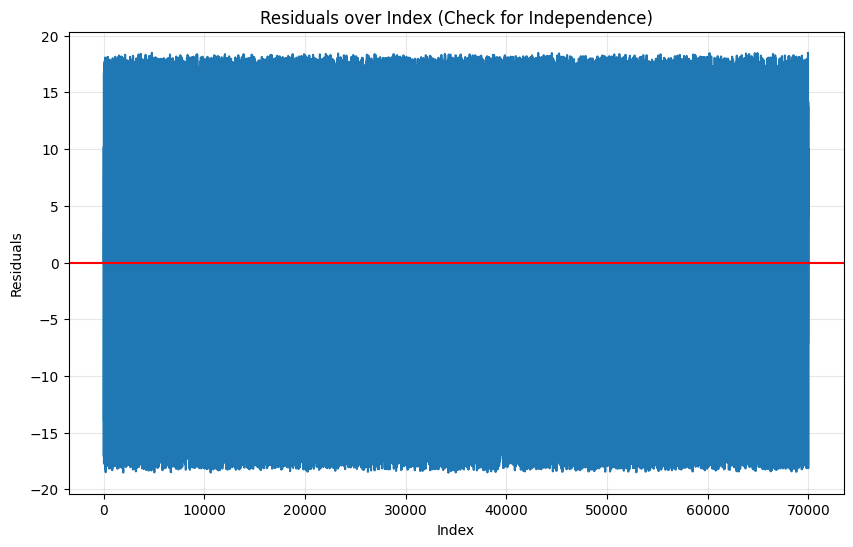


Durbin-Watson Test for Independence of Residuals:
Statistic: 1.9980
Independence Test Passed: True

===== SUMMARY OF LINEAR REGRESSION ASSUMPTIONS =====
1. Multicollinearity (VIF < 10): PASSED
2. Normality of Residuals (Shapiro-Wilk p > 0.05): FAILED
3. Homoscedasticity (Breusch-Pagan p > 0.05): PASSED
4. Independence of Residuals (Durbin-Watson ≈ 2): PASSED

Overall: Some assumptions are violated

Using Random Forest as a non-parametric alternative since some assumptions are violated.

Training Random Forest model...

Random Forest Feature Importance:
                           Feature  Importance
6   Pain in Neck/Jaw/Shoulder/Back    0.073221
8                 Persistent Cough    0.072143
11     Chest Discomfort (Activity)    0.071534
7               Excessive Sweating    0.071377
5                 Swelling (Edema)    0.070690
9                  Nausea/Vomiting    0.070375
2              Irregular Heartbeat    0.068273
12                 Cold Hands/Feet    0.066832
14         Anxiet

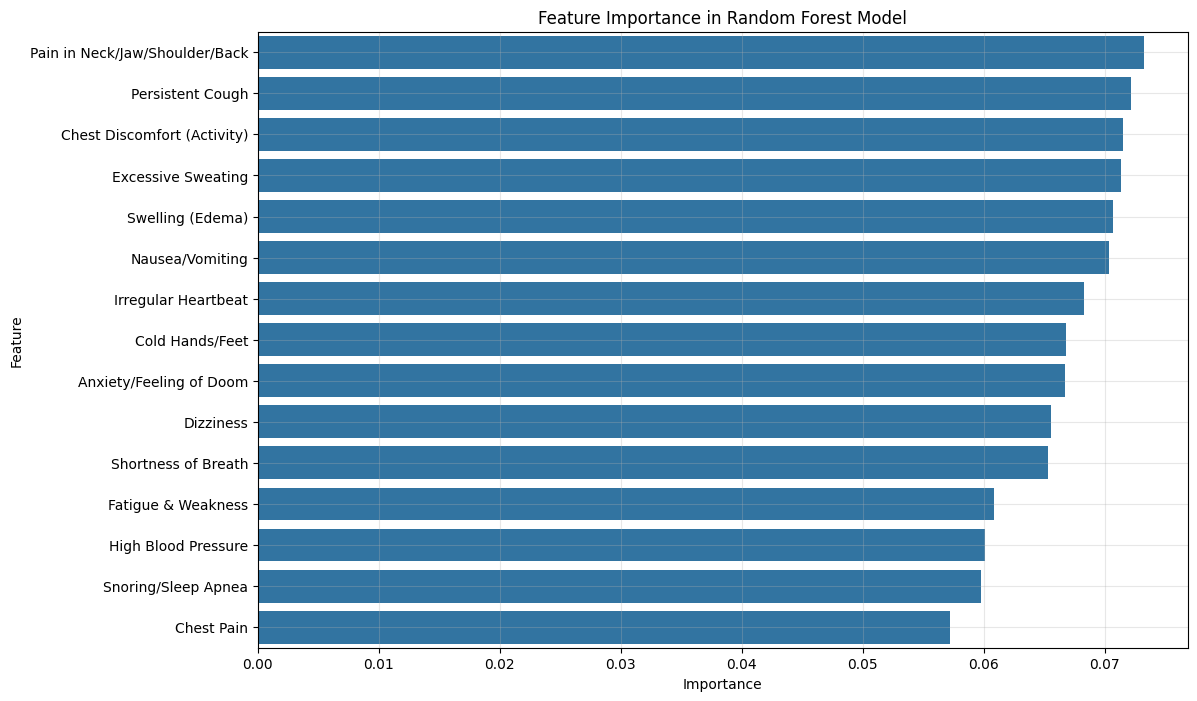


Random Forest - Training Set Metrics:
Mean Squared Error (MSE): 62.0668
Root Mean Squared Error (RMSE): 7.8782
Mean Absolute Error (MAE): 6.3705
R-squared (R²): 0.6976

Random Forest - Testing Set Metrics:
Mean Squared Error (MSE): 142.4771
Root Mean Squared Error (RMSE): 11.9364
Mean Absolute Error (MAE): 9.9779
R-squared (R²): 0.2936


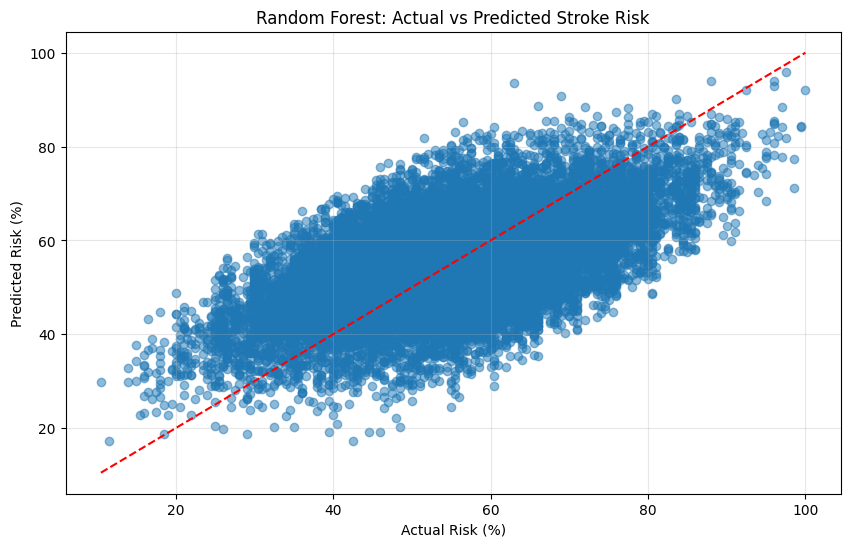

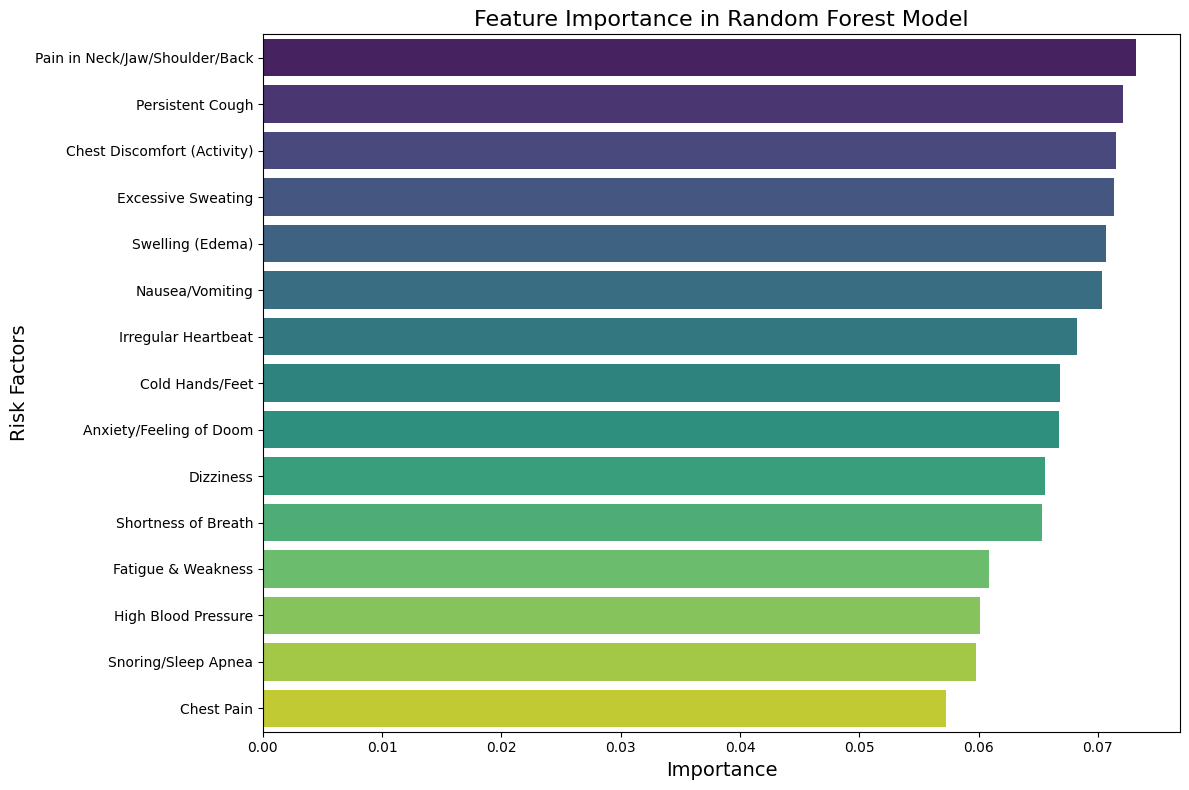

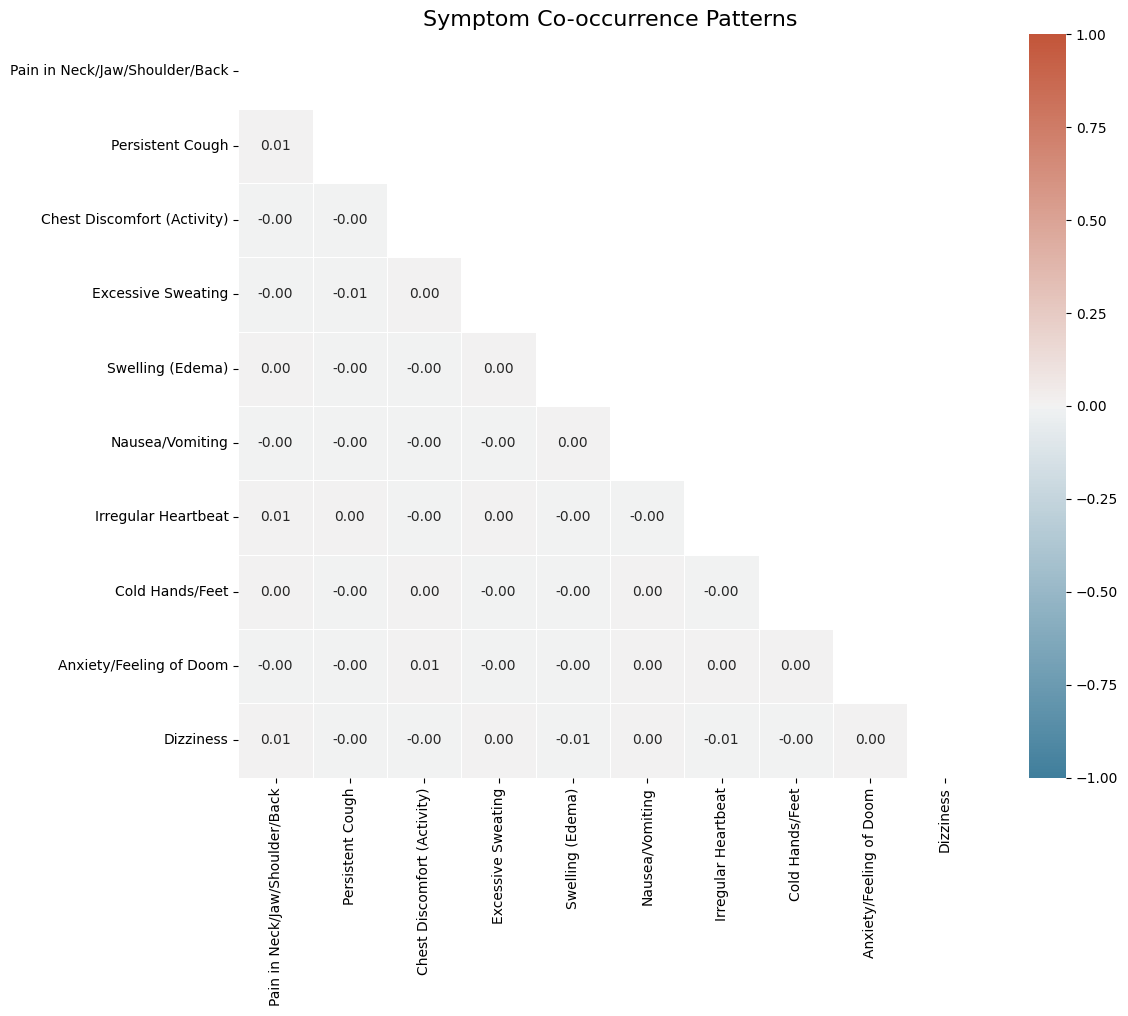

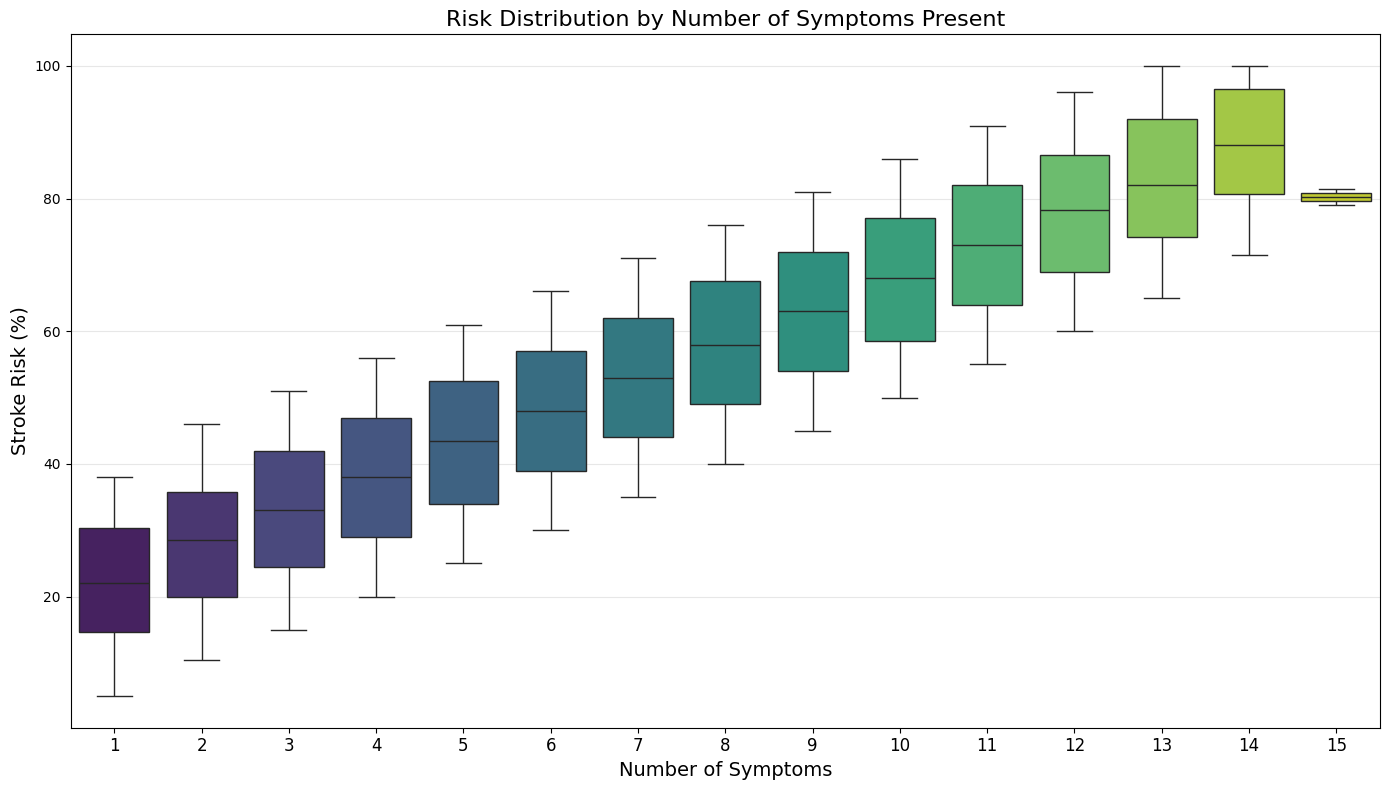

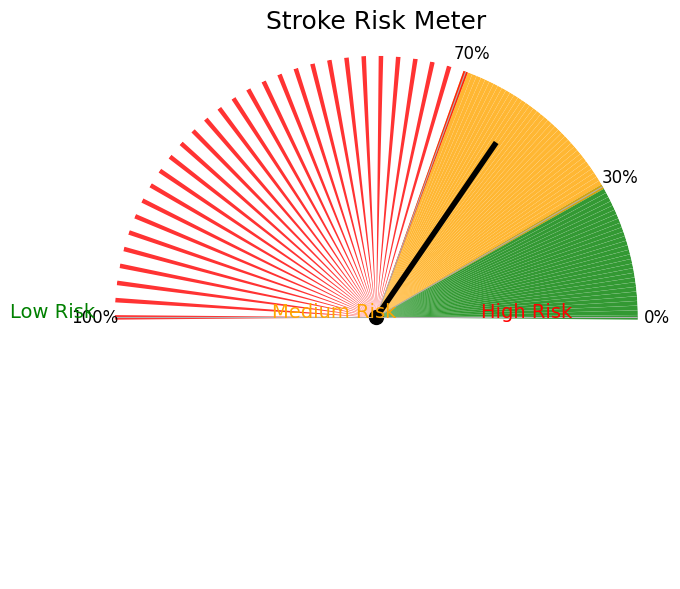

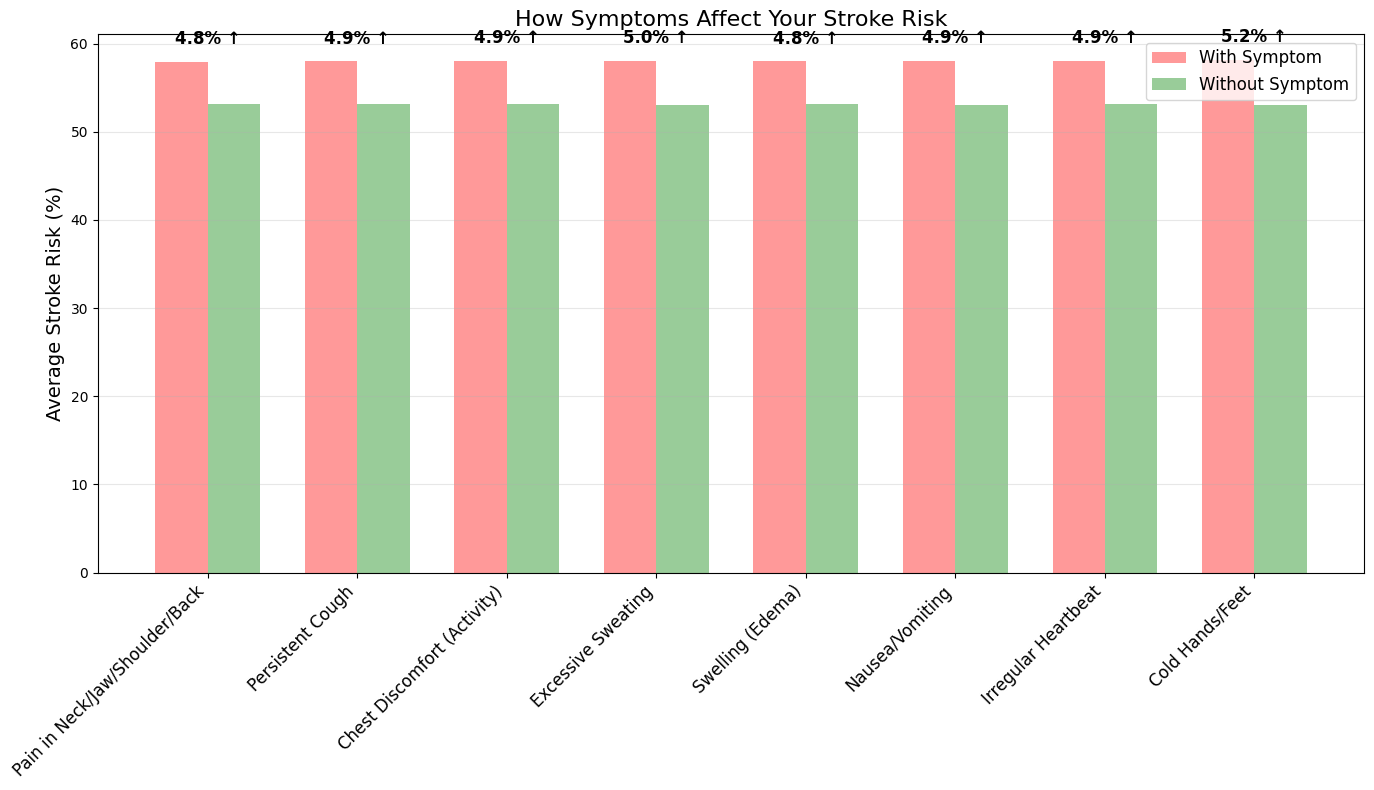

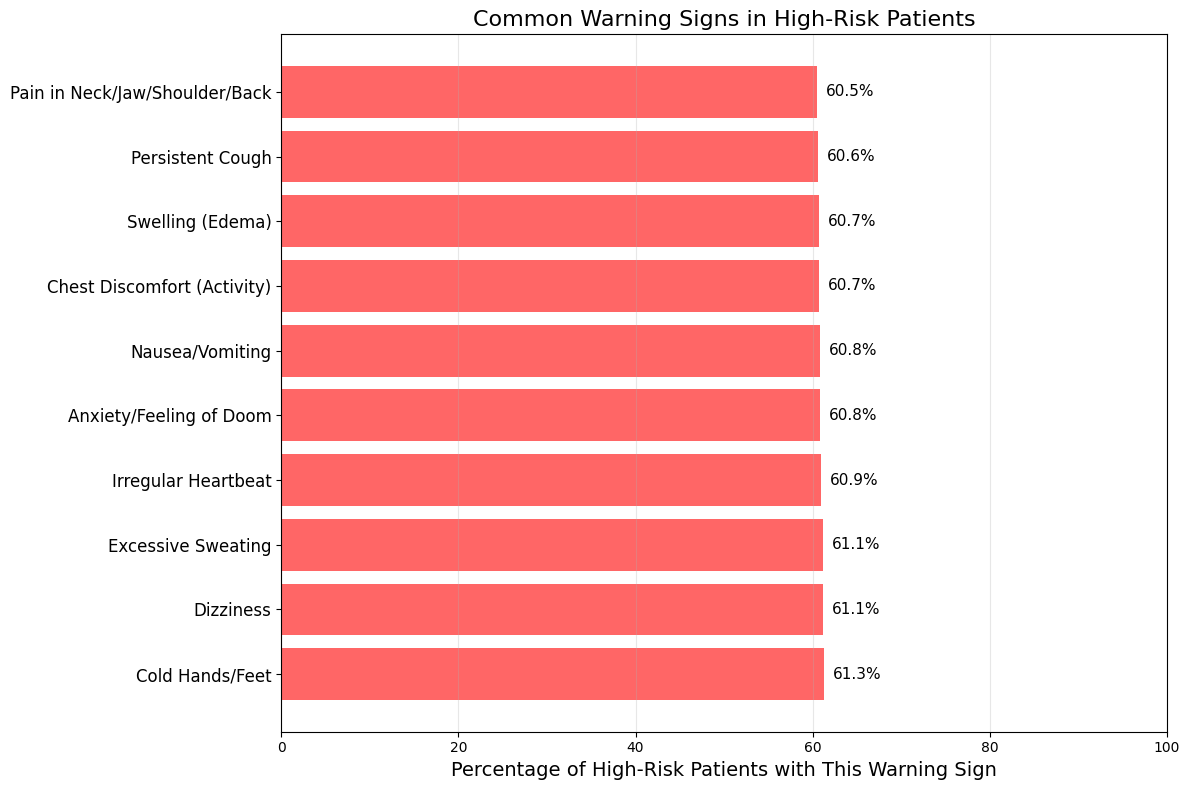

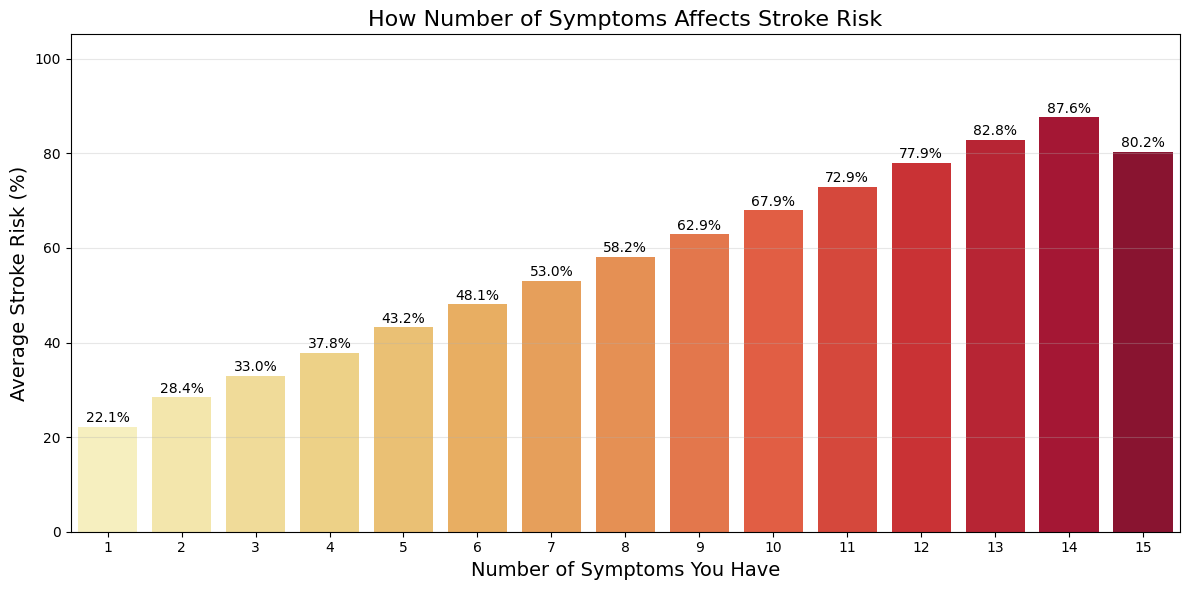

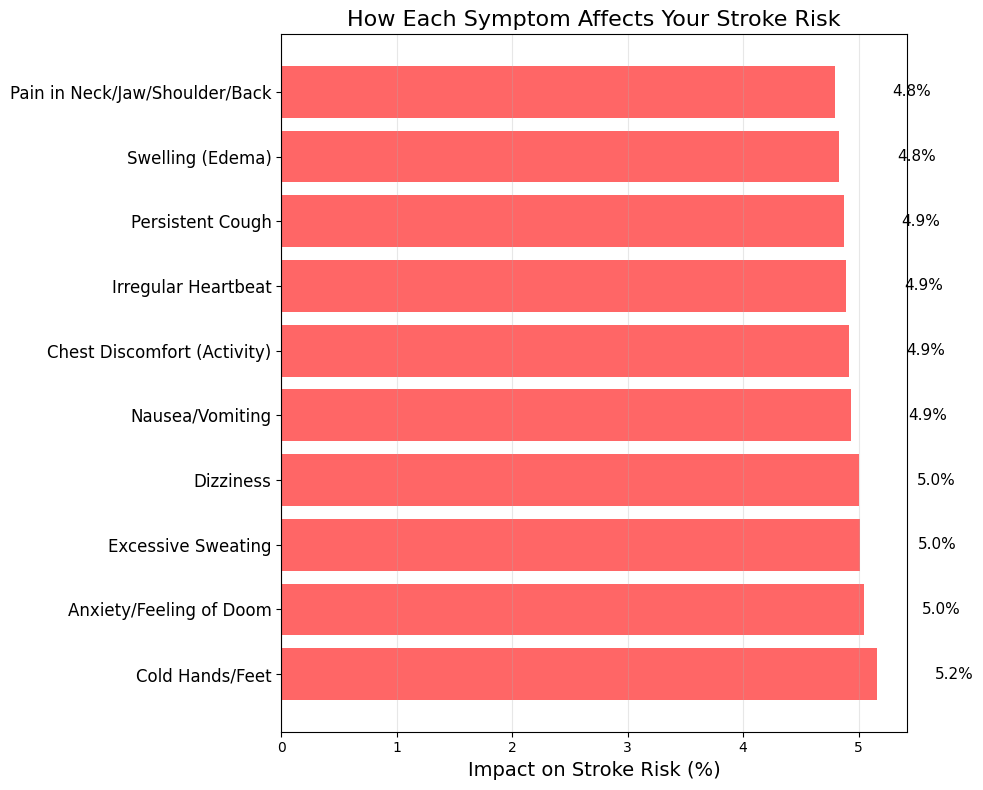


Analysis Complete!


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# File upload in Google Colab
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your CSV file

# Read the uploaded file
import io
df = pd.read_csv(io.BytesIO(uploaded[next(iter(uploaded))]))

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics for the target variable
print("\nStroke Risk (%) Statistics:")
print(df['Stroke Risk (%)'].describe())

# Define predictor variables (excluding Age)
predictors = [
    'Chest Pain', 'Shortness of Breath', 'Irregular Heartbeat',
    'Fatigue & Weakness', 'Dizziness', 'Swelling (Edema)',
    'Pain in Neck/Jaw/Shoulder/Back', 'Excessive Sweating',
    'Persistent Cough', 'Nausea/Vomiting', 'High Blood Pressure',
    'Chest Discomfort (Activity)', 'Cold Hands/Feet',
    'Snoring/Sleep Apnea', 'Anxiety/Feeling of Doom'
]

# Create X and y
X = df[predictors]
y = df['Stroke Risk (%)']

# ------- TEST LINEAR REGRESSION ASSUMPTIONS -------

# 1. Check for multicollinearity using VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Add constant term to X for statsmodels
X_with_const = sm.add_constant(X)
vif_results = calculate_vif(X_with_const)
print("\nVariance Inflation Factors (VIF):")
print(vif_results.sort_values('VIF', ascending=False))
vif_passed = all(vif < 10 for vif in vif_results['VIF'] if vif_results['Variable'][vif_results['VIF'] == vif].values[0] != 'const')
print(f"VIF Test Passed: {vif_passed}")

# 2. Check for linearity
# Fit a statsmodels OLS model to check residuals
model_sm = sm.OLS(y, X_with_const).fit()
residuals = model_sm.resid
fitted_values = model_sm.fittedvalues

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Check for normality of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.grid(True, alpha=0.3)
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print("\nShapiro-Wilk Test for Normality of Residuals:")
print(f"Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")
normality_passed = shapiro_test.pvalue > 0.05
print(f"Normality Test Passed: {normality_passed}")

# 4. Check for homoscedasticity (constant variance)
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, np.abs(residuals), alpha=0.5)
plt.title('Homoscedasticity Check: |Residuals| vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('|Residuals|')
plt.grid(True, alpha=0.3)
plt.show()

# Breusch-Pagan test for homoscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, model_sm.model.exog)
print("\nBreusch-Pagan Test for Homoscedasticity:")
print(f"Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")
homoscedasticity_passed = bp_test[1] > 0.05
print(f"Homoscedasticity Test Passed: {homoscedasticity_passed}")

# 5. Check for independence of residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals over Index (Check for Independence)')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True, alpha=0.3)
plt.show()

# Durbin-Watson test for autocorrelation
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(residuals)
print("\nDurbin-Watson Test for Independence of Residuals:")
print(f"Statistic: {dw_statistic:.4f}")
independence_passed = 1.5 < dw_statistic < 2.5
print(f"Independence Test Passed: {independence_passed}")

# Summary of assumption tests
print("\n===== SUMMARY OF LINEAR REGRESSION ASSUMPTIONS =====")
print(f"1. Multicollinearity (VIF < 10): {'PASSED' if vif_passed else 'FAILED'}")
print(f"2. Normality of Residuals (Shapiro-Wilk p > 0.05): {'PASSED' if normality_passed else 'FAILED'}")
print(f"3. Homoscedasticity (Breusch-Pagan p > 0.05): {'PASSED' if homoscedasticity_passed else 'FAILED'}")
print(f"4. Independence of Residuals (Durbin-Watson ≈ 2): {'PASSED' if independence_passed else 'FAILED'}")

assumptions_met = vif_passed and normality_passed and homoscedasticity_passed and independence_passed
print(f"\nOverall: {'All assumptions are met' if assumptions_met else 'Some assumptions are violated'}")

# Split data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------- MODEL SELECTION BASED ON ASSUMPTIONS -------
if assumptions_met:
    print("\nUsing Linear Regression since all assumptions are met.")
    # Build linear regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Get feature importance from model coefficients
    coef_df = pd.DataFrame({
        'Feature': predictors,
        'Coefficient': model.coef_
    })
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

    print("\nFeature Importance (Model Coefficients):")
    print(coef_df)

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Feature Importance in Linear Regression Model')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\nUsing Random Forest as a non-parametric alternative since some assumptions are violated.")

# In either case, train Random Forest as either primary model or for comparison
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest
rf_y_pred_train = rf_model.predict(X_train)
rf_y_pred_test = rf_model.predict(X_test)

# Get feature importance from Random Forest
rf_importance = pd.DataFrame({
    'Feature': predictors,
    'Importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_importance)

# Visualize RF feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance)
plt.title('Feature Importance in Random Forest Model')
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate models
def evaluate_model(y_true, y_pred, set_name, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} - {set_name} Set Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    return mse, rmse, mae, r2

# Evaluate Random Forest
rf_train_metrics = evaluate_model(y_train, rf_y_pred_train, "Training", "Random Forest")
rf_test_metrics = evaluate_model(y_test, rf_y_pred_test, "Testing", "Random Forest")

# If linear regression was used, evaluate it too
if assumptions_met:
    lr_train_metrics = evaluate_model(y_train, y_pred_train, "Training", "Linear Regression")
    lr_test_metrics = evaluate_model(y_test, y_pred_test, "Testing", "Linear Regression")

    # Compare models
    comparison_df = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
        'Linear Regression': [lr_test_metrics[0], lr_test_metrics[1], lr_test_metrics[2], lr_test_metrics[3]],
        'Random Forest': [rf_test_metrics[0], rf_test_metrics[1], rf_test_metrics[2], rf_test_metrics[3]]
    })

    print("\nModel Comparison (Test Set):")
    print(comparison_df)

    # Visual comparison of actual vs predicted for Linear Regression
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    min_val = min(y_test.min(), y_pred_test.min())
    max_val = max(y_test.max(), y_pred_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Linear Regression: Actual vs Predicted Stroke Risk')
    plt.xlabel('Actual Risk (%)')
    plt.ylabel('Predicted Risk (%)')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visual comparison of actual vs predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred_test, alpha=0.5)
min_val = min(y_test.min(), rf_y_pred_test.min())
max_val = max(y_test.max(), rf_y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title('Random Forest: Actual vs Predicted Stroke Risk')
plt.xlabel('Actual Risk (%)')
plt.ylabel('Predicted Risk (%)')
plt.grid(True, alpha=0.3)
plt.show()

# ------- VISUALIZATIONS FOR HEALTHCARE PROVIDERS -------
# Use the best performing model features
importance_df = rf_importance if not assumptions_met else coef_df

# 1. Enhanced Feature Importance Plot
plt.figure(figsize=(12, 8))
if assumptions_met:
    ax = sns.barplot(x='Abs_Coefficient', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance in Linear Regression Model', fontsize=16)
    plt.xlabel('Absolute Coefficient Value', fontsize=14)
else:
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance in Random Forest Model', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
plt.ylabel('Risk Factors', fontsize=14)
plt.tight_layout()
plt.show()

# 2. Correlation heatmap of top symptoms
top_symptoms = importance_df.head(10)['Feature'].tolist()
symptom_corr = df[top_symptoms].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(symptom_corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(symptom_corr, mask=mask, cmap=cmap, annot=True, fmt='.2f',
            square=True, linewidths=.5, vmin=-1, vmax=1)
plt.title('Symptom Co-occurrence Patterns', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Distribution of risk by number of symptoms
df['Symptom Count'] = df[predictors].sum(axis=1)
plt.figure(figsize=(14, 8))
sns.boxplot(x='Symptom Count', y='Stroke Risk (%)', data=df, palette='viridis')
plt.title('Risk Distribution by Number of Symptoms Present', fontsize=16)
plt.xlabel('Number of Symptoms', fontsize=14)
plt.ylabel('Stroke Risk (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ------- VISUALIZATIONS FOR GENERAL POPULATION -------

# 1. Simplified risk meter using a gauge chart
def gauge_chart(risk_value):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': 'polar'})

    # Define the gauge (half-circle)
    theta = np.linspace(0, 180, 100) * np.pi / 180
    r = np.ones_like(theta)

    # Color segments (Low: 0-30, Medium: 30-70, High: 70-100)
    low = np.linspace(0, 30, 30) * np.pi / 180
    med = np.linspace(30, 70, 40) * np.pi / 180
    high = np.linspace(70, 180, 30) * np.pi / 180  # Changed to match the number of values in r[70:]

    ax.bar(low, r[0:30], width=np.pi/180, color='green', alpha=0.8)
    ax.bar(med, r[30:70], width=np.pi/180, color='orange', alpha=0.8)
    ax.bar(high, r[70:], width=np.pi/180, color='red', alpha=0.8)  # Now the shapes match

    # Needle - adjust angle calculation to match the risk percentage
    needle_angle = (min(risk_value, 100) * np.pi) / 180
    ax.plot([0, needle_angle], [0, 0.8], color='black', linewidth=4)
    ax.scatter(0, 0, color='black', s=100)

    # Customize chart
    ax.set_ylim(0, 1)
    ax.set_frame_on(False)
    ax.set_xticks(np.array([0, 30, 70, 180]) * np.pi / 180)
    ax.set_xticklabels(['0%', '30%', '70%', '100%'], fontsize=12)
    ax.set_yticks([])

    # Labels
    plt.text(-0.2, 0.5, 'Low Risk', transform=ax.transAxes, fontsize=14, color='green')
    plt.text(0.3, 0.5, 'Medium Risk', transform=ax.transAxes, fontsize=14, color='orange')
    plt.text(0.7, 0.5, 'High Risk', transform=ax.transAxes, fontsize=14, color='red')
    plt.title('Stroke Risk Meter', fontsize=18, pad=20)

    plt.tight_layout()
    plt.show()

# Create risk meter with average risk value
gauge_chart(df['Stroke Risk (%)'].mean())

# 2. Top symptoms impact chart
top_symptoms = importance_df.head(8)['Feature'].tolist()
risk_with = []
risk_without = []

for symptom in top_symptoms:
    risk_with.append(df[df[symptom] == 1]['Stroke Risk (%)'].mean())
    risk_without.append(df[df[symptom] == 0]['Stroke Risk (%)'].mean())

plt.figure(figsize=(14, 8))
x = np.arange(len(top_symptoms))
width = 0.35

plt.bar(x - width/2, risk_with, width, label='With Symptom', color='#FF9999')
plt.bar(x + width/2, risk_without, width, label='Without Symptom', color='#99CC99')

plt.ylabel('Average Stroke Risk (%)', fontsize=14)
plt.title('How Symptoms Affect Your Stroke Risk', fontsize=16)
plt.xticks(x, top_symptoms, rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add the difference as text
for i in range(len(top_symptoms)):
    diff = risk_with[i] - risk_without[i]
    plt.text(i, max(risk_with[i], risk_without[i]) + 2,
             f"{abs(diff):.1f}% {'↑' if diff > 0 else '↓'}",
             ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Warning signs visual - sorted by importance
top_symptoms = importance_df.head(10)['Feature'].tolist()
high_risk_threshold = df['Stroke Risk (%)'].quantile(0.75)
high_risk_patients = df[df['Stroke Risk (%)'] >= high_risk_threshold]

symptom_in_high_risk = []
for symptom in top_symptoms:
    symptom_in_high_risk.append(high_risk_patients[symptom].mean() * 100)

# Sort by prevalence
sorted_indices = np.argsort(symptom_in_high_risk)[::-1]
symptom_names = [top_symptoms[i] for i in sorted_indices]
symptom_in_high_risk = [symptom_in_high_risk[i] for i in sorted_indices]

plt.figure(figsize=(12, 8))
y_pos = np.arange(len(symptom_names))

bars = plt.barh(y_pos, symptom_in_high_risk, color='#FF6666')

# Add percentages to the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{symptom_in_high_risk[i]:.1f}%",
             va='center', fontsize=11)

plt.yticks(y_pos, symptom_names, fontsize=12)
plt.xlabel('Percentage of High-Risk Patients with This Warning Sign', fontsize=14)
plt.title('Common Warning Signs in High-Risk Patients', fontsize=16)
plt.xlim(0, 100)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Risk by number of symptoms (simplified for public)
symptom_count_risk = df.groupby('Symptom Count')['Stroke Risk (%)'].mean().reset_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Symptom Count', y='Stroke Risk (%)', data=symptom_count_risk, palette='YlOrRd')
plt.title('How Number of Symptoms Affects Stroke Risk', fontsize=16)
plt.xlabel('Number of Symptoms You Have', fontsize=14)
plt.ylabel('Average Stroke Risk (%)', fontsize=14)

# Add values on top of bars
for i, v in enumerate(symptom_count_risk['Stroke Risk (%)']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.ylim(0, symptom_count_risk['Stroke Risk (%)'].max() * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Symptom checklist with impact values
plt.figure(figsize=(10, 8))
# Create a table-like visualization
table_data = []
for symptom in top_symptoms:
    # Calculate risk difference when symptom is present vs absent
    risk_with = df[df[symptom] == 1]['Stroke Risk (%)'].mean()
    risk_without = df[df[symptom] == 0]['Stroke Risk (%)'].mean()
    diff = risk_with - risk_without
    table_data.append([symptom, diff])

# Sort by impact
table_data.sort(key=lambda x: abs(x[1]), reverse=True)

# Create visual
symptom_names = [item[0] for item in table_data]
impact_values = [item[1] for item in table_data]

# Color bars based on impact
colors = ['#FF6666' if v > 0 else '#66BB66' for v in impact_values]

y_pos = np.arange(len(symptom_names))
bars = plt.barh(y_pos, impact_values, color=colors)

# Add values to the bars
for i, bar in enumerate(bars):
    text_color = 'black'
    text_pos = bar.get_width() + 0.5 if bar.get_width() >= 0 else bar.get_width() - 0.5
    ha = 'left' if bar.get_width() >= 0 else 'right'
    plt.text(text_pos, bar.get_y() + bar.get_height()/2,
             f"{impact_values[i]:.1f}%",
             va='center', ha=ha, fontsize=11, color=text_color)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.yticks(y_pos, symptom_names, fontsize=12)
plt.xlabel('Impact on Stroke Risk (%)', fontsize=14)
plt.title('How Each Symptom Affects Your Stroke Risk', fontsize=16)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nAnalysis Complete!")